In [3]:
import copy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import rootpy
import scipy

import PTI.ReadDataFiles
reload(PTI.ReadDataFiles)
from PTI.ReadDataFiles import PTIData

In [ ]:
def get_QY(pti_blank_data, pti_fluor_data, ex_integration_range, em_integration_range,
           baseline_subtract = True,
           em_correction_array=None):

    b_data = pti_blank_data.get_baseline_subtracted('cor')
    f_data = pti_fluor_data.get_baseline_subtracted('cor')
    
    em_corrected_difference = np.divide(b_data - f_data, em_correction_array)
    
    ex_limits = np.where((pti_blank_data.wavelengths >= ex_integration_range[0]) & 
                         (pti_blank_data.wavelengths <= ex_integration_range[1]))
    num_absorbed = np.trapz(y = em_corrected_difference[ex_limits],
                            x = pti_blank_data.wavelengths[ex_limits],
                            dx= pti_blank_data.step_size)
    
    em_limits = np.where((pti_blank_data.wavelengths >= em_integration_range[0]) & 
                         (pti_blank_data.wavelengths <= em_integration_range[1]))
    num_emitted = np.trapz(y = -em_corrected_difference[em_limits],
                           x = pti_blank_data.wavelengths[em_limits],
                           dx= pti_blank_data.step_size)
    
    return num_emitted/num_absorbed

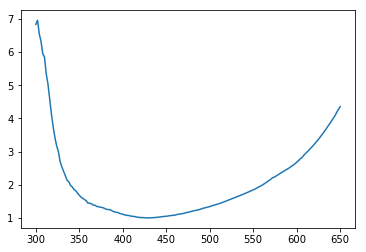

In [118]:
def interpolate_with_avg(array):
    return np.append(np.dstack((array[:-1], array[:-1] + np.diff(array)/2)).ravel(), array[-1])

emcorr_quanta_sphere_wavelengths = np.genfromtxt("PTI/correction_data/emcorr-sphere-quanta.txt", 
                                                 skip_header = 6,
                                                 usecols = 0,
                                                 max_rows = (848-300)/2 +1)
emcorr_quanta_sphere_values = np.genfromtxt("PTI/correction_data/emcorr-sphere-quanta.txt", 
                                            skip_header = 6,
                                            usecols = 1,
                                            max_rows = (848-300)/2 +1)

emcorr_quanta_sphere_wavelengths = interpolate_with_avg(interpolate_with_avg(emcorr_quanta_sphere_wavelengths))
emcorr_quanta_sphere_values = interpolate_with_avg(interpolate_with_avg(emcorr_quanta_sphere_values))


start_wavelength = 300
end_wavelength = 650
desired_wavelengths = np.where((emcorr_quanta_sphere_wavelengths >= start_wavelength) & 
                               (emcorr_quanta_sphere_wavelengths <= end_wavelength))

emcorr_quanta_sphere_values = emcorr_quanta_sphere_values[desired_wavelengths]
plt.plot(emcorr_quanta_sphere_wavelengths[desired_wavelengths],emcorr_quanta_sphere_values)
plt.show()

In [129]:
aug_path_prefix = "Henry/Sphere/PPO_ETOH/"
jun_path_prefix = "Noah/Integrating Sphere Tests for PPO Contamination/"

aug_data_paths = ["EmissionScan_ETOH_ex310_2sec_160830.txt",
                  "EmissionScan_0x31gperL_PPOinETOH_ex310_2sec_160831.txt"]
jun_data_paths = ["EmScan_IS_0x00gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt",
                  "EmScan_IS_0x31gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt"]

aug_data = [PTIData(aug_path_prefix + aug_data_paths[0]),
            PTIData(aug_path_prefix + aug_data_paths[1])]
jun_data = [PTIData(jun_path_prefix + jun_data_paths[0]),
            PTIData(jun_path_prefix + jun_data_paths[1])]


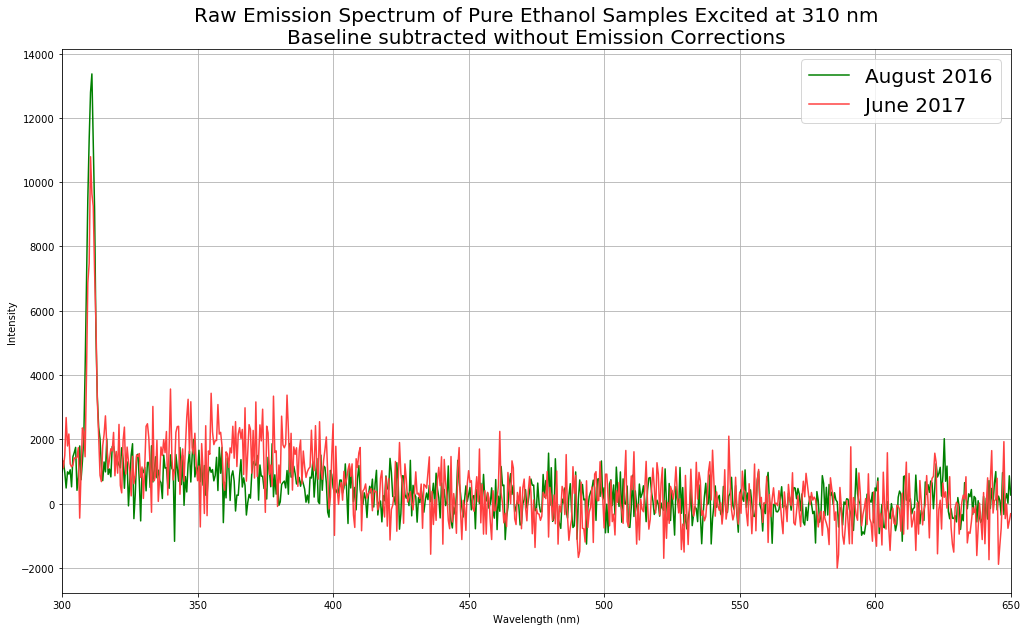

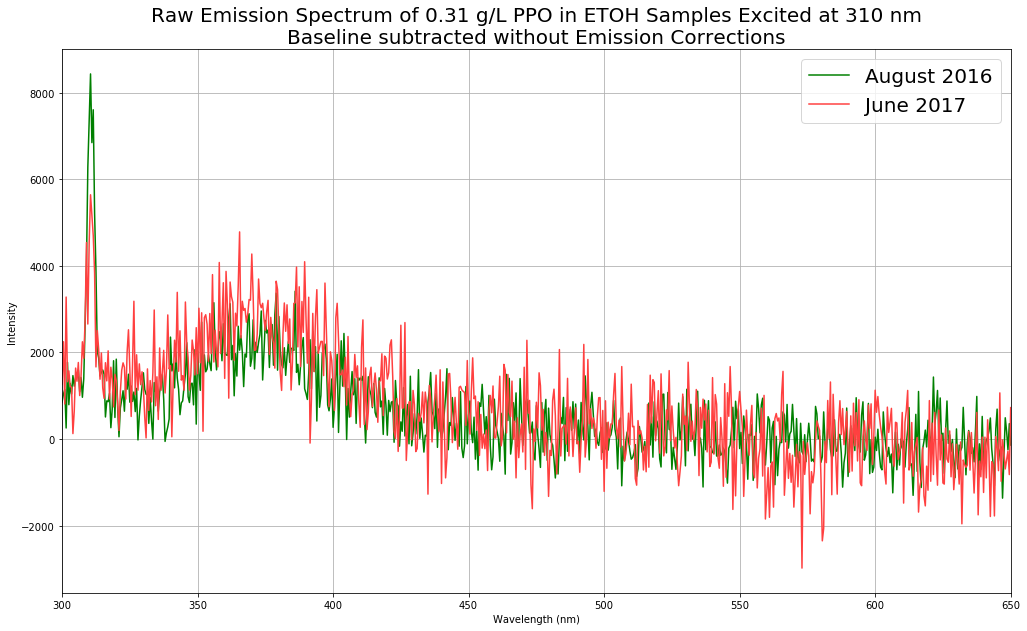

In [132]:
fig, axes = plt.subplots(figsize=(17,10))
plt.plot(aug_data[0].wavelengths, aug_data[0].get_baseline_subtracted('cor'),color='#008000')
plt.plot(jun_data[0].wavelengths, jun_data[0].get_baseline_subtracted('cor'),color="#ff4040")
plt.title("Raw Emission Spectrum of Pure Ethanol Samples Excited at 310 nm\n"+
          "Baseline subtracted without Emission Corrections",
                fontsize=20)
plt.xlabel("Wavelength (nm)")
plt.xlim(aug_data[0].em_range)
plt.ylabel("Intensity")
plt.legend(["August 2016","June 2017"],prop={'size':20})
plt.grid()
plt.show()

fig, axes = plt.subplots(figsize=(17,10))
plt.plot(aug_data[1].wavelengths, aug_data[1].get_baseline_subtracted('cor'),color='#008000')
plt.plot(jun_data[1].wavelengths, jun_data[1].get_baseline_subtracted('cor'),color="#ff4040")
plt.title("Raw Emission Spectrum of 0.31 g/L PPO in ETOH Samples Excited at 310 nm\n" +
          "Baseline subtracted without Emission Corrections",
          fontsize=20)
plt.xlabel("Wavelength (nm)")
plt.xlim(aug_data[0].em_range)
plt.ylabel("Intensity")
plt.legend(["August 2016","June 2017"],prop={'size':20})
plt.grid()
plt.show()

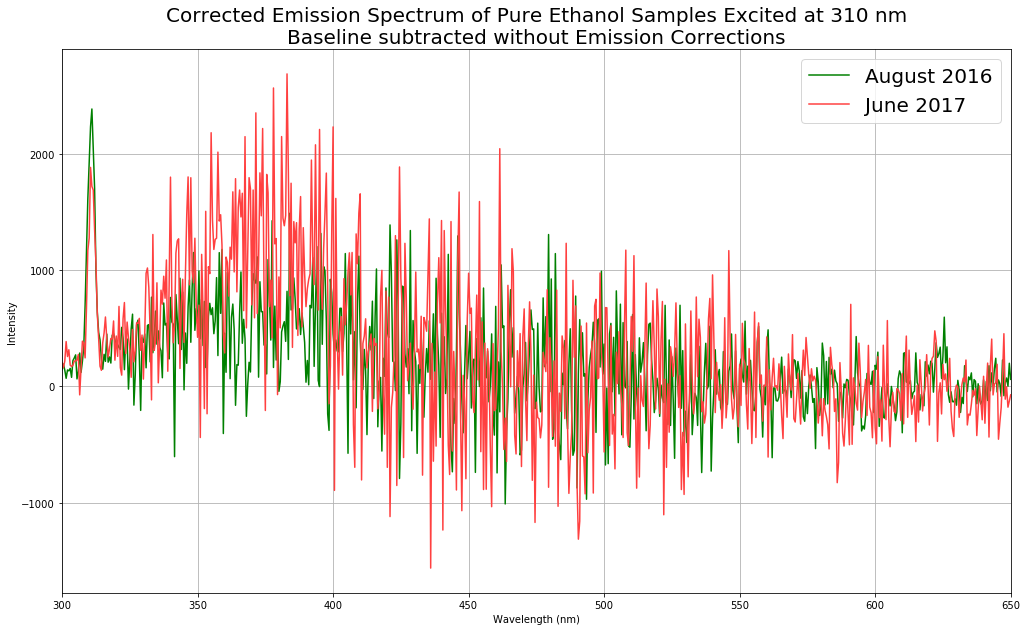

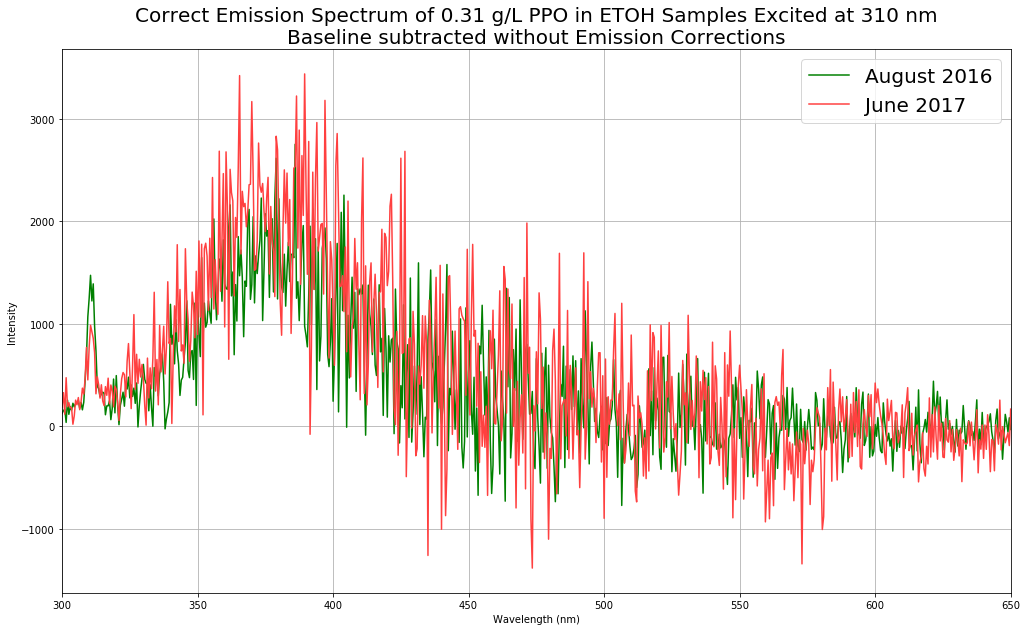

In [121]:
fig, axes = plt.subplots(figsize=(17,10))
plt.plot(aug_data[0].wavelengths, 
         np.divide(aug_data[0].get_baseline_subtracted('cor'),emcorr_quanta_sphere_values),
         color='#008000')
plt.plot(jun_data[0].wavelengths, 
         np.divide(jun_data[0].get_baseline_subtracted('cor'),emcorr_quanta_sphere_values),
         color="#ff4040")
plt.title("Corrected Emission Spectrum of Pure Ethanol Samples Excited at 310 nm\n"+
          "Baseline subtracted without Emission Corrections",
                fontsize=20)
plt.xlabel("Wavelength (nm)")
plt.xlim(aug_data[0].em_range)
plt.ylabel("Intensity")
plt.legend(["August 2016","June 2017"],prop={'size':20})
plt.grid()
plt.show()

fig, axes = plt.subplots(figsize=(17,10))
plt.plot(aug_data[1].wavelengths, 
         np.divide(aug_data[1].get_baseline_subtracted('cor'),emcorr_quanta_sphere_values),
         color='#008000')
plt.plot(jun_data[1].wavelengths, 
         np.divide(jun_data[1].get_baseline_subtracted('cor'),emcorr_quanta_sphere_values),
         color="#ff4040")
plt.title("Correct Emission Spectrum of 0.31 g/L PPO in ETOH Samples Excited at 310 nm\n" +
          "Baseline subtracted without Emission Corrections",
          fontsize=20)
plt.xlabel("Wavelength (nm)")
plt.xlim(aug_data[0].em_range)
plt.ylabel("Intensity")
plt.legend(["August 2016","June 2017"],prop={'size':20})
plt.grid()
plt.show()

In [122]:
# Calculate QY
### AUGUST ###

path_prefix = "Henry/Sphere/PPO_ETOH/"

# In order of: No PPO, 0.31 g/L, 3.14 g/L
data_file_names = ["EmissionScan_ETOH_ex310_2sec_160830.txt",
                   "EmissionScan_0x31gperL_PPOinETOH_ex310_2sec_160831.txt"]

# Will be a list of PTIData class instances
data = list()
colors = ['#008000', '#3399ff', '#ff7f50']

for i in range(0,2):
    data.append(PTIData(path_prefix + data_file_names[i]))    

ex_int_range = [305,320]
em_int_range = [330,450]
ex_int_idx = np.where((data[0].wavelengths >= ex_int_range[0]) & (data[0].wavelengths <= ex_int_range[1]))
em_int_idx = np.where((data[0].wavelengths >= em_int_range[0]) & (data[0].wavelengths <= em_int_range[1]))

QY1 = get_QY(data[0], data[1], 
             ex_int_range, em_int_range, 
             raw_or_cor = 'cor', 
             baseline_subtract = True, 
             em_correction_array = emcorr_quanta_sphere_values) 

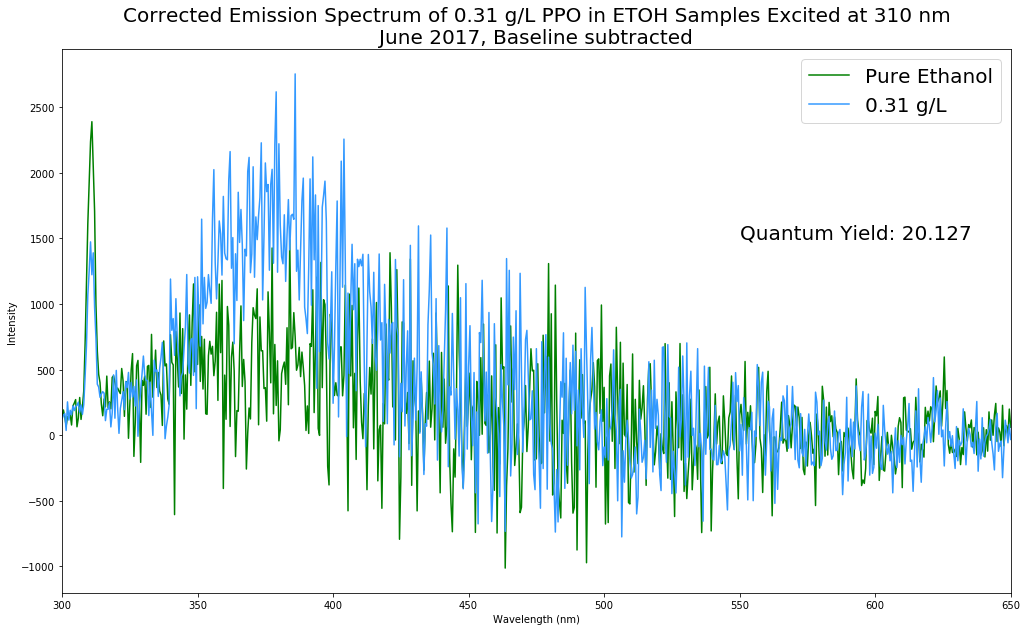

In [123]:
fig = plt.subplots(figsize=(17,10))
y0 = np.divide(data[0].get_baseline_subtracted('cor'),emcorr_quanta_sphere_values)
y1 = np.divide(data[1].get_baseline_subtracted('cor'),emcorr_quanta_sphere_values)

plt.plot(data[0].wavelengths, 
         y0,
         colors[0])
plt.plot(data[1].wavelengths, 
         y1,
         colors[1])

plt.text(550,1500,"Quantum Yield: %.3f" %QY1,fontsize=20)

plt.title("Corrected Emission Spectrum of 0.31 g/L PPO in ETOH Samples Excited at 310 nm\n"+
                "June 2017, Baseline subtracted",
                fontsize=20)
plt.xlabel("Wavelength (nm)")
plt.xlim(data[0].em_range)
plt.ylabel("Intensity")
plt.legend(["Pure Ethanol", "0.31 g/L"],prop={'size':20})
plt.show()

In [124]:
# Calculate QY
### JUNE ###

path_prefix = "Noah/Integrating Sphere Tests for PPO Contamination/"

# In order of: No PPO, 0.31 g/L, 3.14 g/L
data_file_names = ["EmScan_IS_0x00gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt",
                   "EmScan_IS_0x31gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt"]

# Will be a list of PTIData class instances
data = list()
colors = ['#008000', '#3399ff', '#ff7f50']

for i in range(0,2):
    data.append(PTIData(path_prefix + data_file_names[i]))    

ex_int_range = [305,320]
em_int_range = [330,450]
ex_int_idx = np.where((data[0].wavelengths >= ex_int_range[0]) & (data[0].wavelengths <= ex_int_range[1]))
em_int_idx = np.where((data[0].wavelengths >= em_int_range[0]) & (data[0].wavelengths <= em_int_range[1]))

QY1 = get_QY(data[0], data[1], 
             ex_int_range, em_int_range, 
             raw_or_cor = 'cor', 
             baseline_subtract = True, 
             em_correction_array = emcorr_quanta_sphere_values) 

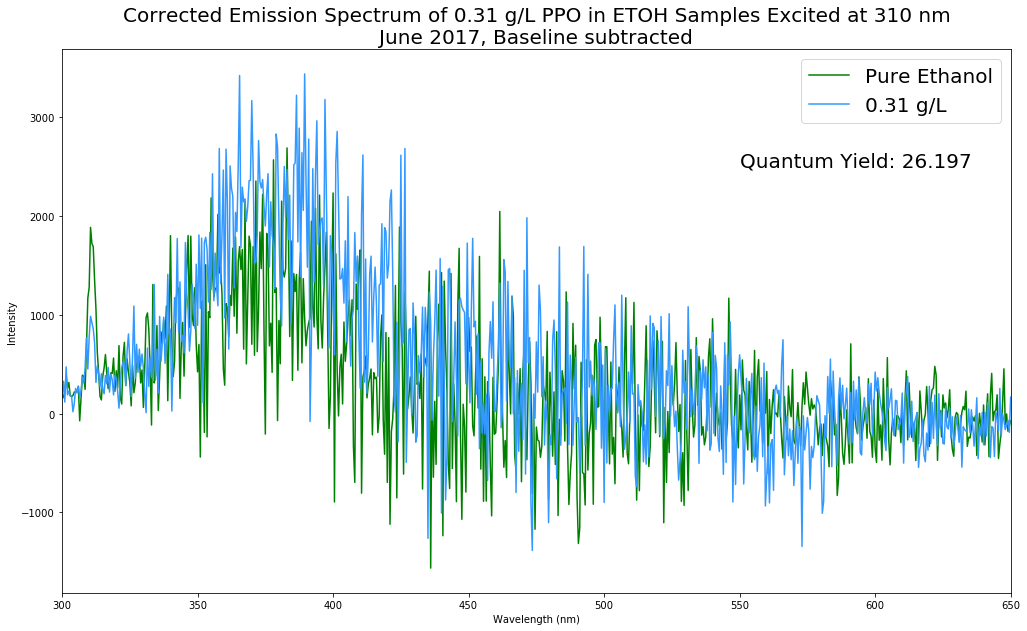

In [125]:
fig = plt.subplots(figsize=(17,10))
y0 = np.divide(data[0].get_baseline_subtracted('cor'),emcorr_quanta_sphere_values)
y1 = np.divide(data[1].get_baseline_subtracted('cor'),emcorr_quanta_sphere_values)

plt.plot(data[0].wavelengths, 
         y0,
         colors[0])
plt.plot(data[1].wavelengths, 
         y1,
         colors[1])

plt.text(550,2500,"Quantum Yield: %.3f" %QY1,fontsize=20)

plt.title("Corrected Emission Spectrum of 0.31 g/L PPO in ETOH Samples Excited at 310 nm\n"+
                "June 2017, Baseline subtracted",
                fontsize=20)
plt.xlabel("Wavelength (nm)")
plt.xlim(data[0].em_range)
plt.ylabel("Intensity")
plt.legend(["Pure Ethanol", "0.31 g/L"],prop={'size':20})
plt.show()